In [278]:
from pathlib import Path
import random

import pandas as pd
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
import ndjson

import numpy as np

from numpy import trapz

In [445]:
sns.set_style("whitegrid")

sns.set(
    font_scale=1.5,
    rc={
        "font.family": "sans-serif",
        "font.size": 16.0,
        "figure.figsize": (11.69, 8.27),
    }
)

tqdm.pandas()

In [2]:
# Data directories
data_dir = Path("../data")

raw_dir = data_dir / "raw"
pubmed_dir = raw_dir / "pubmed"
scite_dir = raw_dir / "scite"

processed_dir = data_dir / "processed"

results_dir = data_dir / "results"

### Load datasets

In [3]:
# Load seed citations
seed_f = pubmed_dir / "seed.csv"
seed_dois = pd.read_csv(seed_f)
seed_dois = seed_dois.doi.tolist()

# Load incoming citations for seed
seed_citations_f = scite_dir / "seed_incoming_citations.jsonl"
seed_citations = pd.read_json(seed_citations_f, orient="records", lines=True)

# Load seed article metadata
seed_articles_file = scite_dir / "seed_papers.jsonl"
seed_articles = pd.read_json(seed_articles_file, lines=True)

source_dois = seed_citations.source.unique().tolist()

In [5]:
# Load metadata for citing articles
source_articles_file = scite_dir / "incoming_papers.jsonl"
source_articles = pd.read_json(source_articles_file, lines=True)

# Load citations for citing articles
source_citations_file = scite_dir / "incoming_citations.jsonl"
source_citations = pd.read_json(source_citations_file, lines=True)

# Limit citations to those that have citing_dois as their source
source_citations = source_citations[source_citations.source.isin(source_dois)]

## Preprocess collected data

In [6]:
# Merge papaer metadata
articles = pd.concat([seed_articles, source_articles])
articles = articles.drop_duplicates(subset="doi").set_index("doi")

In [7]:
# Merge citations | needs to be intersection!
citations = pd.concat([seed_citations, source_citations])
citations = citations.drop_duplicates(subset="id")

In [8]:
# Drop citations with missing source DOIs to branch_articles
extra_dois = seed_citations[~seed_citations.source.isin(source_citations.source)].source
citations = citations[~citations.source.isin(extra_dois)]

In [9]:
#####################################
# Filter out article types/keywords #
#####################################

# Filter out some articles
bad_keywords = ["Erratum", "Correction", "COMMENTARY"]
good_types = ["journal-article", "proceedings-article", "book-chapter", "posted-content"]

# 
dropped_articles = []
for i, a in articles.iterrows():
    if a.type not in good_types:
        dropped_articles.append(i)
        continue
    
    for k in bad_keywords:
        if type(a.keywords) is list:
            if k in a.keywords:
                dropped_articles.append(i)
                continue
                
articles = articles.drop(index=dropped_articles)
citations = citations[~citations.source.isin(dropped_articles)]

In [10]:
# Citing articles which cite another citing article
print("total citing articles:", citations.source.nunique())

print("articles that cite seed:", citations[citations.target.isin(seed_dois)].source.nunique())
print("articles that cite another source citations", citations[(citations.source.isin(source_dois)) & (citations.target.isin(source_dois))].source.nunique())
print("articles that cite other target articles", citations[(~citations.target.isin(seed_dois)) & (~citations.target.isin(source_dois))].source.nunique())

total citing articles: 9848
articles that cite seed: 9848
articles that cite another source citations 4459
articles that cite other target articles 9847


In [11]:
print("total cited articles", citations.target.nunique())
print("seed articles that were cited by source", citations[citations.target.isin(seed_dois)].target.nunique())
print("source articles that were cited by source", citations[citations.target.isin(source_dois)].target.nunique())

total cited articles 439959
seed articles that were cited by source 998
source articles that were cited by source 3148


In [381]:
# Remove two DOIs from the seed set which weren't found in the full citations list
final_dois = citations[citations.target.isin(seed_dois)].target.unique().tolist()
seed_citations = seed_citations[seed_citations.target.isin(final_dois)]

## Contexts

In [230]:
articles

,slug,type,title,abstract,authors,keywords,year,shortJournal,publisher,issue,volume,page,retracted,memberId,issns,editorialNotices,journalSlug,journal,rwStatus
doi,,,,,,,,,,,,,,,,,,,
10.1371/journal.pone.0159593,shared-genetic-factors-involved-in-j81d1l,journal-article,Shared Genetic Factors Involved in Celiac Dise...,Background and ObjectivesGenome-wide associati...,"[{'family': 'Mostowy', 'given': 'Joanna'}, {'f...",[Research Article],2016.0,PLoS ONE,Public Library of Science (PLoS),8,11,e0159593,0.0,340,[1932-6203],[],plos-one-lZbEk,Plos One,NaN
10.1080/21541248.2016.1276999,molecular-control-of-rab-activity-kpJgay,journal-article,"Molecular control of Rab activity by GEFs, GAP...",ABSTRACTRab proteins are the major regulators ...,"[{'family': 'Müller', 'given': 'Matthias P.'},...",[Review],2017.0,Small GTPases,Informa UK Limited,1-2,9,5-21,0.0,301,"[2154-1248, 2154-1256]",[],small-gtpases-YZrGD,Small GTPases,NaN
10.1101/gad.281030.116,codon-usage-affects-the-structure-Zwy9Zp,journal-article,Codon usage affects the structure and function...,\nCodon usage bias is a universal feature of a...,"[{'family': 'Fu', 'given': 'Jingjing'}, {'fami...","[[Keywords: circadian clock, codon usage, Dros...",2016.0,Genes Dev.,Cold Spring Harbor Laboratory,15,30,1761-1775,0.0,246,"[0890-9369, 1549-5477]",[],genes-development-6828p,Genes & Development,NaN
10.3389/fnins.2016.00235,positron-emission-tomography-reveals-abnormal-...,journal-article,Positron Emission Tomography Reveals Abnormal ...,Recent studies have demonstrated alterations i...,"[{'family': 'Qiu', 'given': 'Xiangzhe'}, {'fam...",[Neuroscience],2016.0,Front. Neurosci.,Frontiers Media SA,NaN,10,NaN,0.0,1965,[1662-453X],[],frontiers-in-neuroscience-RVvG4,Frontiers in Neuroscience,NaN
10.1007/s00439-016-1683-5,the-hnrnp-family-insights-into-V23EgE,journal-article,The hnRNP family: insights into their role in ...,Heterogeneous nuclear ribonucleoproteins (hnRN...,"[{'family': 'Geuens', 'given': 'Thomas'}, {'fa...",[Review],2016.0,Hum Genet,Springer Science and Business Media LLC,8,135,851-867,0.0,297,"[0340-6717, 1432-1203]",[],human-genetics-vJNKJ,Human Genetics,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1101/357681,draft-genome-sequences-ofhirudo-medicinalisand...,posted-content,Draft genome sequences ofHirudo medicinalisand...,\nSalivary cell secretion (SCS) plays a critic...,"[{'family': 'Babenko', 'given': 'Vladislav V.'...",[],2018.0,NaN,Cold Spring Harbor Laboratory,NaN,NaN,NaN,0.0,246,[],[],NaN,,NaN
10.1371/journal.pntd.0006235,microexon-gene-transcriptional-profiles-and-pJ...,journal-article,Microexon gene transcriptional profiles and ev...,BackgroundAdult schistosomes have a well-devel...,"[{'family': 'Li', 'given': 'Xiao-Hong'}, {'fam...",[Research Article],2018.0,PLoS Negl Trop Dis,Public Library of Science (PLoS),2,12,e0006235,0.0,340,[1935-2735],"[{'status': 'new_version', 'date': '2018-02-23...",plos-neglected-tropical-diseases-G3lNA,PLOS Neglected Tropical Diseases,NaN
10.1159/000489645,a-tick-cysteine-protease-inhibitor-QeOPpOJ,journal-article,A Tick Cysteine Protease Inhibitor RHcyst-1 Ex...,\nBackground/Aims: We previously identified a ...,"[{'family': 'Wei', 'given': 'Nana'}, {'family'...",[Original Paper],2018.0,Cell Physiol Biochem,S. Karger AG,6,46,2385-2400,0.0,127,"[1015-8987, 1421-9778]",[],cellular-physiology-and-biochemistry-2NO6m,Cellular Physiology and Biochemistry,NaN


## Traces

In [364]:
traces = seed_citations[["id", "source", "target", "snippet", "refLocation", "section"]].copy().set_index("id")
traces

,source,target,snippet,refLocation,section
id,,,,,
1603221744,10.3390/toxins11080443,10.3389/fneur.2017.00535,Most chronic inflammatory CNS disorders have a...,b14-toxins-11-00443/1,1. Introduction
1603221770,10.3390/toxins11080443,10.3389/fneur.2017.00535,The belief that fungi play an important role i...,b14-toxins-11-00443/2,3. Discussion
1589211783,10.3389/fneur.2019.00758,10.3389/fneur.2017.00535,The potential role of microbes and viruses in ...,b18/1,Introduction
1589211918,10.3389/fneur.2019.00758,10.3389/fneur.2017.00535,MS has many direct links with the immune respo...,b18/2,Malassezia Primer
1589211932,10.3389/fneur.2019.00758,10.3389/fneur.2017.00535,"MS is moderately associated with SpA (113, <ci...",b18/3,Malassezia Primer
...,...,...,...,...,...
1071932729,10.1159/000489645,10.3389/fcimb.2017.00216,"To date, approximately 20 tick cystatins, all ...",ref48/1,Discussion
1478093524,10.3389/fcimb.2017.00476,10.3389/fcimb.2017.00216,Protease inhibitors has also been extensively ...,b23/1,Discussion
1506573001,10.1093/gbe/evx279,10.3389/fcimb.2017.00216,"2014, <cite data-doi=""10.1074/jbc.m112.339051""...",evx279-b25/1,Results


## Patterns for source articles

In [366]:
# Metrics for citing (source) article
source_articles = pd.DataFrame(index=citations.source.drop_duplicates())
source_articles["total_source_mentions"] = citations.groupby("source").target.size()
source_articles["total_source_refs"] = citations.groupby("source").target.nunique()

source_articles["mean_source_mentions"] = source_articles["total_source_mentions"] / source_articles["total_source_refs"]
source_articles

,total_source_mentions,total_source_refs,mean_source_mentions
source,,,
10.3390/toxins11080443,44,37,1.189189
10.3389/fneur.2019.00758,280,125,2.240000
10.3389/fmicb.2018.02968,69,64,1.078125
10.15419/bmrat.v6i12.579,53,39,1.358974
10.3389/fmicb.2018.03249,142,100,1.420000
...,...,...,...
10.1101/357681,69,57,1.210526
10.1371/journal.pntd.0006235,86,41,2.097561
10.1159/000489645,46,41,1.121951


## Mention patterns

In [367]:
mention_pattern_cols = ["id", "source", "target", "negative", "neutral", "positive", "type", "typeConfidence", "expertClassification"]
mention_patterns = seed_citations[mention_pattern_cols].set_index("id")
mention_patterns

,source,target,negative,neutral,positive,type,typeConfidence,expertClassification
id,,,,,,,,
1603221744,10.3390/toxins11080443,10.3389/fneur.2017.00535,0.003697,1.0,0.008609,mentioning,1.0,NaN
1603221770,10.3390/toxins11080443,10.3389/fneur.2017.00535,0.005248,1.0,0.019753,mentioning,1.0,NaN
1589211783,10.3389/fneur.2019.00758,10.3389/fneur.2017.00535,0.008267,1.0,0.005143,mentioning,1.0,NaN
1589211918,10.3389/fneur.2019.00758,10.3389/fneur.2017.00535,0.004740,1.0,0.006388,mentioning,1.0,NaN
1589211932,10.3389/fneur.2019.00758,10.3389/fneur.2017.00535,0.050479,1.0,0.010640,mentioning,1.0,NaN
...,...,...,...,...,...,...,...,...
1071932729,10.1159/000489645,10.3389/fcimb.2017.00216,0.002939,1.0,0.004096,mentioning,1.0,NaN
1478093524,10.3389/fcimb.2017.00476,10.3389/fcimb.2017.00216,0.009755,1.0,0.062056,mentioning,1.0,NaN
1506573001,10.1093/gbe/evx279,10.3389/fcimb.2017.00216,0.026799,1.0,0.060917,mentioning,1.0,NaN


## Citation Patterns

In [368]:
citation_patterns = traces[["source", "target"]].drop_duplicates(ignore_index=True).set_index(["source", "target"])
citation_patterns = traces.groupby(["source", "target"]).size().reset_index(name="mentions")

refs_norm = 1/source_articles["total_source_refs"].to_frame("refs_norm")
citation_patterns = citation_patterns.merge(refs_norm, left_on="source", right_index=True, how="left")
citation_patterns = citation_patterns[~citation_patterns.isna().any(axis=1)]

citation_patterns = citation_patterns.merge(source_articles["total_source_mentions"], left_on="source", right_index=True, how="left")
citation_patterns = citation_patterns.merge(source_articles["mean_source_mentions"], left_on="source", right_index=True, how="left")

# Normalize by total mentions
citation_patterns["mentions_norm_total"] = citation_patterns["mentions"] / citation_patterns["total_source_mentions"]

# Normalize by mean mentions
citation_patterns["mentions_norm_mean"] = citation_patterns["mentions"] / citation_patterns["mean_source_mentions"]

citation_patterns

,source,target,mentions,refs_norm,total_source_mentions,mean_source_mentions,mentions_norm_total,mentions_norm_mean
0,10.1001/jama.2017.20885,10.1093/jnen/nlx101,1,0.040000,34,1.360000,0.029412,0.735294
1,10.1001/jama.2019.16161,10.1038/ng.3482,3,0.111111,15,1.666667,0.200000,1.800000
2,10.1001/jamadermatol.2018.4673,10.1186/s13023-017-0718-x,1,0.050000,28,1.400000,0.035714,0.714286
3,10.1001/jamanetworkopen.2019.6972,10.1089/jpm.2017.0548,1,0.023810,46,1.095238,0.021739,0.913043
4,10.1001/jamaneurol.2018.0035,10.1172/jci.insight.89530,1,0.034483,56,1.931034,0.017857,0.517857
...,...,...,...,...,...,...,...,...
11011,10.7916/tohm.v0.712,10.3390/ijms17020189,1,0.034483,39,1.344828,0.025641,0.743590
11012,10.9734/afsj/2020/v14i330131,10.1016/j.tins.2016.09.002,1,0.111111,9,1.000000,0.111111,1.000000
11013,10.9734/ejmp/2019/v28i230129,10.1155/2017/9208489,1,0.166667,6,1.000000,0.166667,1.000000
11014,10.9734/ejnfs/2019/v11i330148,10.1186/s12284-017-0157-2,1,0.333333,3,1.000000,0.333333,1.000000


## Article Patterns

In [436]:
article_patterns = pd.DataFrame(index=final_dois)

# Aggregate counts
article_patterns["refs_agg"] = citation_patterns.groupby("target").size()
article_patterns["mentions_agg"] = citation_patterns.groupby("target")["mentions"].sum()

# normalized 
article_patterns["refs_norm_agg"] = citation_patterns.groupby("target")["refs_norm"].sum()
article_patterns["eng_norm_avg"] = citation_patterns.groupby("target")["mentions_norm_mean"].mean()

# score
article_patterns["score"] = article_patterns.apply(lambda row: compute_score(row.name), axis=1)

article_patterns

,refs_agg,mentions_agg,refs_norm_agg,eng_norm_avg,score
10.3389/fneur.2017.00535,6,13,0.091612,1.347773,0.515279
10.1016/j.clinph.2018.04.747,3,4,0.091580,1.000784,0.583921
10.3390/ijms18081638,18,23,0.352699,0.925604,0.508652
10.1038/srep19230,15,49,0.306009,1.656534,0.222246
10.1186/s13287-018-0890-5,4,6,0.127793,1.190518,0.597451
...,...,...,...,...,...
10.2174/1570159x15666170102145257,3,3,0.070047,0.902576,0.798156
10.1177/0306312715619783,4,9,0.198035,1.323061,0.481403
10.3390/toxins10010006,2,2,0.023598,0.588253,0.475322
10.1155/2017/3978595,5,6,0.066101,0.965926,0.460103


## Plots

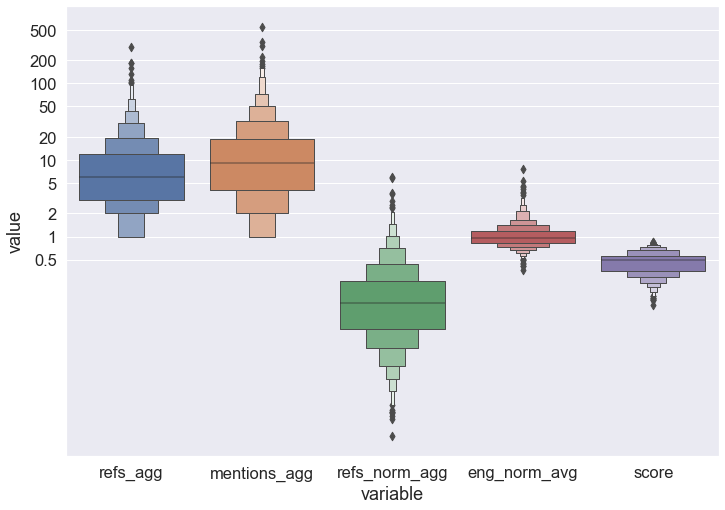

In [446]:
pdf = np.log10(article_patterns).melt()
sns.boxenplot(data=pdf, x="variable", y="value")

yticks = [.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]
plt.yticks(ticks=np.log10(yticks), labels=yticks);

In [443]:
article_patterns.sort_values("score")

,refs_agg,mentions_agg,refs_norm_agg,eng_norm_avg,score
10.3390/nu10101398,24,50,0.421751,1.273067,0.127791
10.1083/jcb.201709055,10,22,0.171325,1.432670,0.148280
10.1038/nature17623,299,547,5.744652,1.190008,0.150074
10.1002/wps.20490,50,96,1.612225,1.169472,0.154214
10.1371/journal.pcbi.1005941,19,41,0.280669,1.386587,0.158562
...,...,...,...,...,...
10.1038/cddis.2016.475,15,16,0.231428,0.745813,0.818269
10.1093/gerona/gly207,4,4,0.064590,0.899295,0.820412
10.3389/fgene.2016.00100,5,5,0.394793,0.691558,0.822077
10.1039/c6cc00095a,4,4,0.068735,0.919096,0.840830


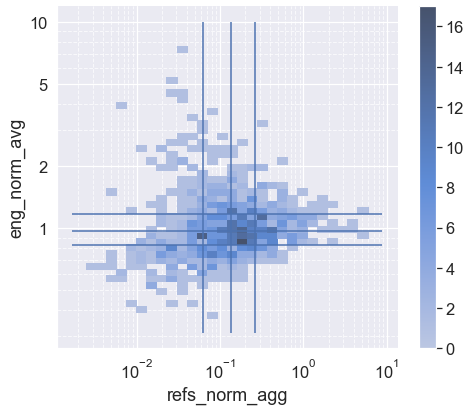

In [447]:
## Citations vs median weighted citation count
y = "eng_norm_avg"
x = "refs_norm_agg"
pdf = article_patterns
sns.displot(data=pdf, x=x, y=y,
            log_scale=(True, True), cbar=True, height=6, aspect=1.2)

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

yticks = [1, 2, 5, 10]
plt.yticks(ticks=yticks, labels=yticks)
# xticks = [1,2,5,10, 20, 50, 100, 200, 500]
# plt.xticks(ticks=xticks, labels=xticks);

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_patterns[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_patterns[x].quantile([.25, .5, .75])], y0, y1)

In [467]:
citation_patterns[citation_patterns.target=="10.1101/cshperspect.a022814"]

,source,target,mentions,refs_norm,total_source_mentions,mean_source_mentions,mentions_norm_total,mentions_norm_mean
940,10.1007/164_2017_48,10.1101/cshperspect.a022814,1,0.007353,274,2.014706,0.003650,0.496350
1524,10.1016/j.celrep.2018.04.109,10.1101/cshperspect.a022814,1,0.018868,70,1.320755,0.014286,0.757143
2156,10.1016/j.tig.2018.09.006,10.1101/cshperspect.a022814,1,0.009709,266,2.582524,0.003759,0.387218
2198,10.1016/j.yebeh.2018.08.016,10.1101/cshperspect.a022814,1,0.032258,44,1.419355,0.022727,0.704545
4003,10.1101/2020.06.15.151720,10.1101/cshperspect.a022814,1,0.027027,50,1.351351,0.020000,0.740000
6735,10.1242/jeb.179747,10.1101/cshperspect.a022814,1,0.030303,47,1.424242,0.021277,0.702128
7333,10.17352/jnnsd.000032,10.1101/cshperspect.a022814,1,0.016129,68,1.096774,0.014706,0.911765
8140,10.3389/fcell.2020.528742,10.1101/cshperspect.a022814,1,0.025641,72,1.846154,0.013889,0.541667
9794,10.3390/ijms18112269,10.1101/cshperspect.a022814,1,0.009009,121,1.090090,0.008264,0.917355
9924,10.3390/ijms20030729,10.1101/cshperspect.a022814,1,0.028571,45,1.285714,0.022222,0.777778


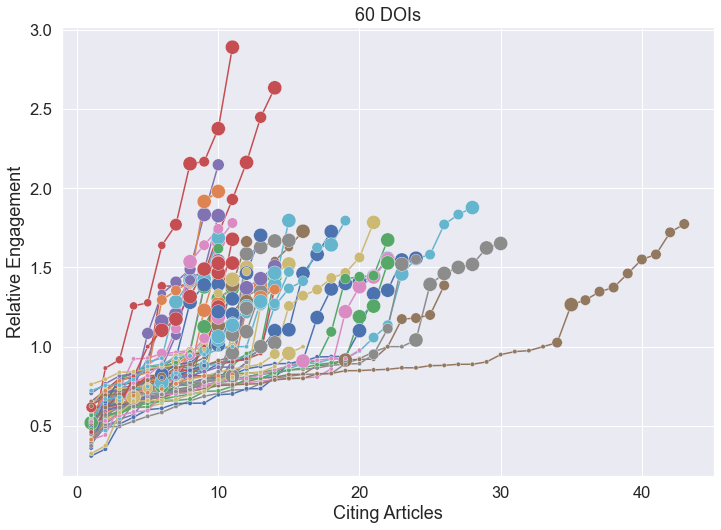

In [504]:
dois = article_patterns[
    (article_patterns.refs_agg>=10) &
    (article_patterns.score>=.5)
].index

s = article_profiles(dois)

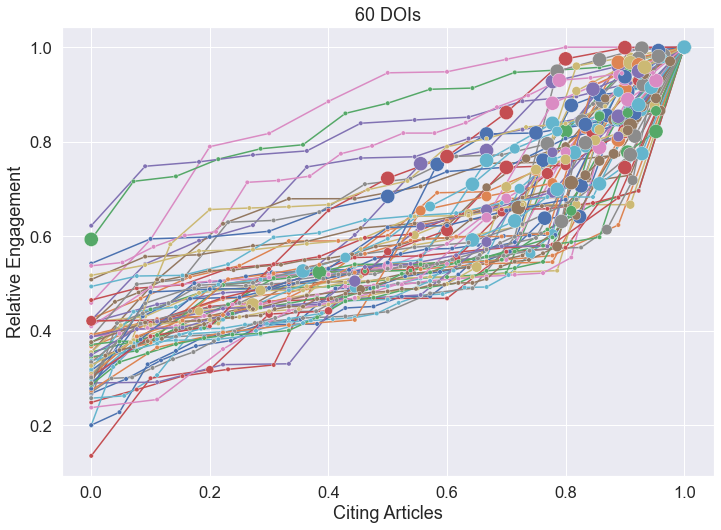

In [505]:
dois = article_patterns[
    (article_patterns.refs_agg>=10) &
    (article_patterns.score>=.5)
].index

s = article_profiles2(dois, norm_refs=True, norm_eng=True)

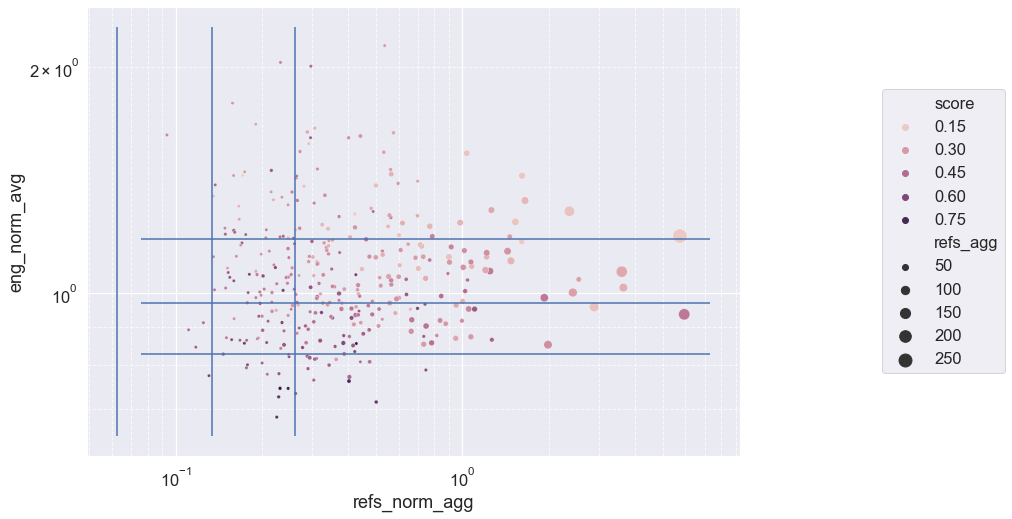

In [455]:
## Citations vs median weighted citation count
y = "eng_norm_avg"
x = "refs_norm_agg"

# pdf["wf1_agg_log"] = np.log10(pdf["wf1_agg"])

pdf = article_patterns[article_patterns.refs_agg>=10]

sns.scatterplot(data=pdf,
                y=y,
                x=x,
                size="refs_agg",
                hue="score", sizes=(10, 200)
               )
plt.legend(loc="right", bbox_to_anchor=(1.42, 0.5));

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

plt.loglog()

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_patterns[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_patterns[x].quantile([.25, .5, .75])], y0, y1)

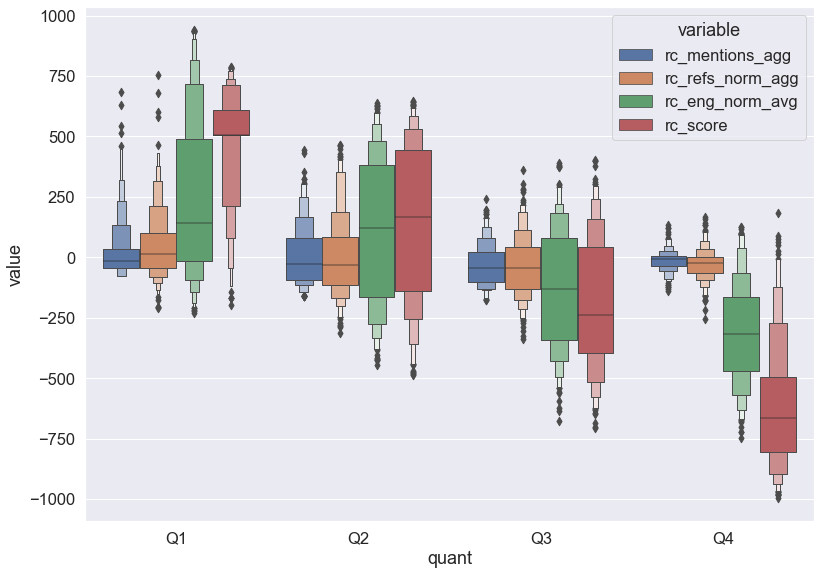

In [484]:
n_quantiles = 5
base_var = "refs_agg"
count_methods = ["mentions_agg", "refs_norm_agg", "eng_norm_avg", "score"]

df = article_patterns
df = df[[base_var] + count_methods].rank()
for cm in count_methods:
    df["rc_" + cm] = df[cm] - df[base_var]

labels = [f"Q{_}" for _ in range(1, n_quantiles)]

pdf = df.reset_index()
pdf = pdf.join(pd.qcut(pdf[base_var], n_quantiles-1, duplicates="drop", labels=labels).to_frame("quant"))
pdf = pdf.melt(id_vars=["quant", "index"], value_vars=["rc_" + cm for cm in count_methods])

sns.boxenplot(data=pdf, hue="variable", y="value", x="quant")
plt.tight_layout()

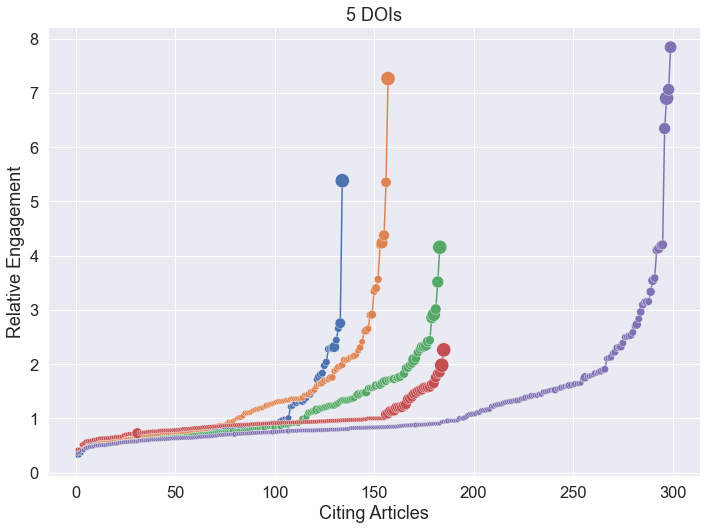

In [483]:
dois = article_patterns.sort_values("refs_agg").tail(5).index
s = article_profiles(dois, norm_refs=False)

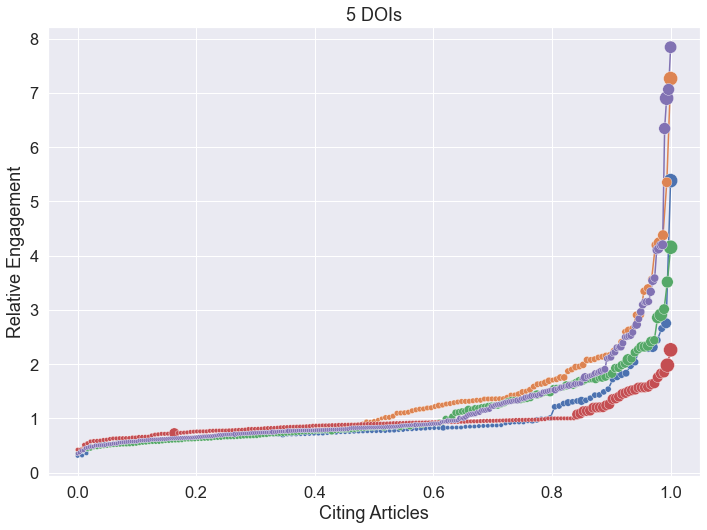

In [503]:
dois = article_patterns.sort_values("refs_agg").tail(5).index
s = article_profiles(dois, norm_refs=True)

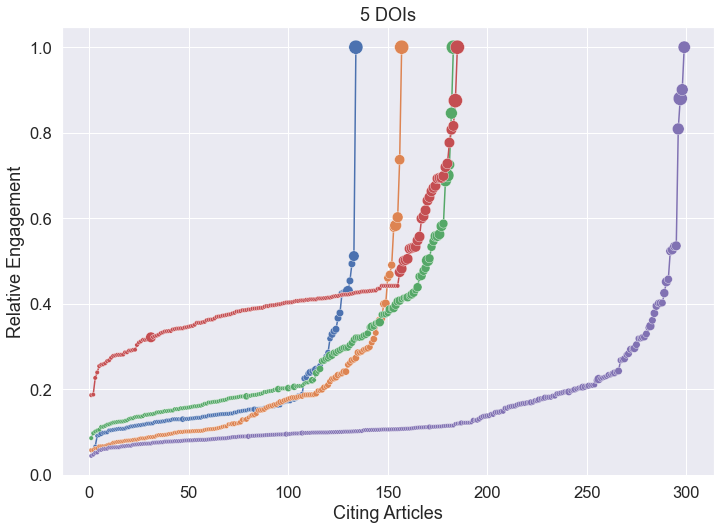

In [480]:
dois = article_patterns.sort_values("refs_agg").tail(5).index
s = article_profiles(dois, norm_eng=True)

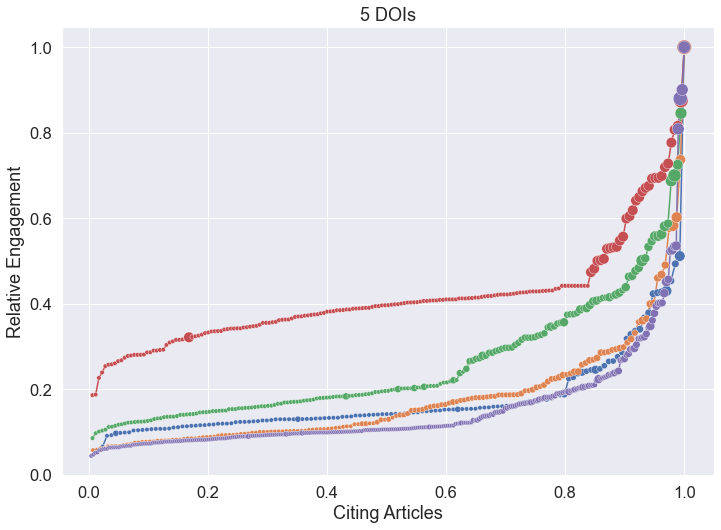

In [500]:
dois = article_patterns.sort_values("refs_agg").tail(5).index
s = article_profiles(dois, norm_refs=True, norm_eng=True)

In [501]:
s

{'10.1007/s00439-016-1683-5': 0.1752398781431248,
 '10.1016/j.cell.2016.10.002': 0.1744991660612485,
 '10.1038/nrm.2016.116': 0.25514891699171244,
 '10.1186/s12943-017-0663-2': 0.41260069095032337,
 '10.1038/nature17623': 0.1505028305636306}

In [498]:
def compute_score(doi: str, pattern: str =  "mentions_norm_mean") -> float:
    df = citation_patterns[citation_patterns.target==doi].copy()
    
    # sort values
    df = df.sort_values(pattern)
    
    # normalize both dimensions
    df["x_perc"] = df[pattern].rank(method="first") - 1
    df["x_perc"] = df["x_perc"] / df["x_perc"].max()
    df[pattern] = df[pattern] / df[pattern].max()
    
    return trapz(df[pattern], df["x_perc"])

In [165]:
def article_citations(df: pd.DataFrame, doi: str) -> pd.DataFrame:
    return df[df.target==doi].sort_values("eng_norm")

In [462]:
def article_profile(doi: str, norm_refs=False, norm_eng=False) -> None:
    pdf = citation_patterns[citation_patterns.target==doi]

#     pdf["collaboration"] = pdf["common_authors"] > 0
    y = "mentions_norm_mean"
    sort_by = y
    pdf["x_order"] = pdf[sort_by].rank(method="first")
    pdf = pdf.sort_values(sort_by)

    sns.lineplot(data=pdf, x="x_order", y=y, zorder=1)
    sns.scatterplot(data=pdf, x="x_order", y=y, size="mentions",
                    sizes=(20,200), legend=True, zorder=2, palette="Set2")
    plt.title(f"DOI: {doi}")
    plt.xlabel("Citing Articles")
    plt.ylabel("Relative Engagement");
#     plt.grid(False, axis="x")

In [502]:
def article_profiles(dois:List, pattern:str="mentions_norm_mean", norm_refs=False, norm_eng=False) -> None:
    fig, ax = plt.subplots(1, 1)
    scores = {}
    for doi in tqdm(dois):
        pdf = citation_patterns[citation_patterns.target==doi].copy()
        pdf = pdf.sort_values(pattern)
        
        if norm_refs:
            pdf["x_perc"] = pdf[pattern].rank(method="first") - 1
            pdf["x_perc"] = pdf["x_perc"] / pdf["x_perc"].max()
        else:
            pdf["x_perc"] = pdf[pattern].rank(method="first")
            
        if norm_eng:
            pdf[pattern] = pdf[pattern] / pdf[pattern].max()
        
        sns.lineplot(data=pdf, x="x_perc", y=pattern, zorder=1, ax=ax)
        sns.scatterplot(data=pdf, x="x_perc", y=pattern, size="mentions", ax=ax,
                        sizes=(20,200), legend=False, zorder=2, palette="Set2")
        
        scores[doi] = compute_score(doi)
    plt.title(f"{len(dois)} DOIs")
    plt.xlabel("Citing Articles")
    plt.ylabel("Relative Engagement");
    
    return scores